<a href="https://colab.research.google.com/github/Center-for-Atmospheric-Research-ATMOS/SR-data-analysis/blob/main/background_subtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of background removal methods for XPS

The first step in the spectra fitting process is usually removal of the background.
The shape of the baseline mainly stems from secondary excited electrons, tails from nearby peaks and energy losses by electrons due to inelastic interactions.

The proper procedure is essential for a qualitative and quantitative analysis of XPS data especially if several components interfere in one spectrum or the signal is a low and noisy.
The choice of an adequate background model is determined by the physical and chemical conditions of the measurements and the significance of the background to the information to be obtained.
There are 3 most popular ways of baseline approximation:

1.   Linear background
2.   Shirley background
3.   Tougaard background

Linear background is self-explanatory - this is just a straight line $y(x) = ax + b$ from the point with the minimum kinetic/binding energy to the maximum, sometimes chosen "by eye".
This is a subjective and robust, but simple way to solve the issue. 

More complex and precise approach is a Shirley baseline which turned out to be a successful approximation for the inelastic background of core level peaks of buried species, which suffered significantly from inelastic losses of the emitted photoelectrons.
In this case we assume, that the background is proportional to the area of the peak above the background to higher kinetic energies.
The analytical expression for the Shirley background is

$$I_b(E)= \int_{E}^{∞}F(E')dE'+C$$

where $I_b$ is the background function, $E$ - kinetic energy, C - constant component of the background.

Proctor and Sherwood proposed the simple algorithm based on the assumption that for every point of the spectrum the background intensity generated by a photoelectron line is proportional to the number of all photoelectrons with higher kinetic energy.
In this case we can write the intensity of the background $I(i)$ in channel $i$ as:

$$I(i)=\frac{(I_1-I_2)Q(i)}{P(i)+Q(i)}+I_2$$

where $I_1$ and $I_2$ are the measured intensities in channel $i{_1}$ and $i{_2}$, respectively, and $P(i)$ and $Q(i)$ represent the effective peak areas to lower and higher kinetic energies relative to the channel under consideration.
$P(i)$, $Q(i)$ and $U(i)$ are unknown, the calculation of the baseline is an iterative procedure with 1st approximation of $U(i) = I_2$.
The number of iteration cycles should be chosen high enough so that the shape of the obtained background function does not change anymore.
The Shirley baseline is widely used since the algoritm is simple and can be easily implemented and at the same time the results obtained are quite accurate.

The Tougaard background relies on a quantitative description of the physical processes that lead to the background.
It takes into account the probability for one electron to lose energy and the electron mean free path, which depends on kinetic energy of electrons in measured flux.
It would be difficult to calculate, but fortunately the background appeared to be not very sensitive to the energy of the electrons. 
That allows to approximate it by a universal semi-imperical function, which proved to be a good approximation for most materials:

$$λ(E)K(E,T) \sim BT/(C + T^2)^2 $$

where $λ(E)$ is a electron mean free path, $K(E,T)$ is the probability that the electron with kinetic energy of $E$ will loose a portion of energy $T$ per unit path length, $B \sim 2886$ $eV^2$ and $C \sim 1643$ $eV^2$ are imperical coefficients.

In [13]:
#@title This cell loads algoritms
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit


def getShirley(x: np.ndarray, y: np.ndarray, window = 30, tol=1e-5, maxit=50):
    """
    Calculate the best auto-Shirley background for a dataset (x,y). Finds the 
    biggest peak and then uses the minimum value either side of this peak as 
    the terminal points of the Shirley background. The tolerance tol sets the 
    convergence criterion, maxit sets the maximum number of iterations.
    """
    x = np.array(x)
    y = np.array(y.rolling(window).median().interpolate(method='nearest').ffill().bfill())
    # Sanity check: Do we actually have data to process here?
    if not (x.any() and y.any()):
        print("[WARNING] One of the arrays x or y is empty. Returning zero background.")
        return np.zeros(x.shape)
    

    # Next ensure the energy values are *decreasing* in the array,
    # if not, reverse them.
    if x[0] < x[-1]:
        is_reversed = True
        x = x[::-1]
        y = y[::-1]
    else:
        is_reversed = False

    maxidx = abs(y - np.amax(y)).argmin() # Locate the biggest peak.

    ## It's possible that maxidx will be 0 or -1. If that is the case,
    ## we can't use this algorithm, we return a zero background.
    if maxidx == 0 or maxidx >= len(y) - 1:
        print('[WARNING] Boundaries too high for algorithm: returning a zero background.')
        return np.zeros(x.shape)

    # Locate the minima either side of maxidx.
    lmidx = abs(y[0:maxidx] - np.amin(y[0:maxidx])).argmin()
    rmidx = abs(y[maxidx:] - np.amin(y[maxidx:])).argmin() + maxidx
    xl = x[lmidx]
    yl = y[lmidx]
    xr = x[rmidx]
    yr = y[rmidx]

    # Max integration index
    imax = rmidx - 1

    # Initial value of the background shape B. The total background S = yr + B,
    # and B is equal to (yl - yr) below lmidx and initially zero above.
    B = np.zeros(x.shape)
    B[:lmidx] = yl - yr
    Bnew = B.copy()

    it = 0
    while it < maxit:
        # Calculate new k = (yl - yr) / (int_(xl)^(xr) J(x') - yr - B(x') dx')
        ksum = 0.0
        for i in range(lmidx, imax):
            ksum += (x[i] - x[i + 1]) * 0.5 * (y[i] + y[i + 1]
                                                - 2 * yr - B[i] - B[i + 1])
        k = (yl - yr) / ksum
        # Calculate new B
        for i in range(lmidx, rmidx):
            ysum = 0.0
            for j in range(i, imax):
                ysum += (x[j] - x[j + 1]) * 0.5 * (
                    y[j] + y[j + 1] - 2 * yr - B[j] - B[j + 1])
            Bnew[i] = k * ysum
        # If Bnew is close to B, exit.
        if np.linalg.norm(Bnew - B) < tol:
            B = Bnew.copy()
            break
        else:
            B = Bnew.copy()
        it += 1
    if is_reversed:
        return (yr + B)[::-1]
    else:
        return yr + B


def getTougaard(x: np.ndarray, y: np.ndarray, window = 30, tb=2866, tc=1643, tcd = 1, td=1, maxit=50):
    """
    Calculate the best auto-Tougaard background for a dataset (x,y). Maxit sets
    the maximum number of iterations, tb and tc are imperical coefficients.
    """
    x = np.array(x)
    y = np.array(y.rolling(window).median().interpolate(method='nearest').ffill().bfill())
    # Sanity check: Do we actually have data to process here?
    if not (any(x) and any(y)):
        print("One of the arrays x or y is empty. Returning zero background.")
        return np.zeros(x.shape)

	# KE in XPS or PE in XAS
    if x[0] < x[-1]:
        is_reversed = True
        x = x[::-1]
        y = y[::-1]
    else:
        is_reversed = False

    Btou = np.zeros(x.shape)

    it = 0
    while it < maxit:
        for i in range(len(y)-1, -1, -1):
            Bint = 0
            for j in range(len(y)-1, i-1, -1):
                Bint += (y[j] - y[len(y)-1]) * (x[0] - x[1]) * (x[i] - x[j]
                ) / ((tc + tcd * (x[i] - x[j])**2)**2 + td * (x[i] - x[j])**2)
            Btou[i] = Bint * tb

        Boffset = Btou[0] - (y[0] - y[len(y)-1])
        if abs(Boffset) < (0.000001 * Btou[0]) or maxit == 1:
            break
        else:
            tb = tb - (Boffset/Btou[0]) * tb * 0.5
        it += 1

    if is_reversed:
        return (y[len(y) - 1] + Btou)[::-1]
    else:
        return y[len(y) - 1] + Btou


def fitCurve(x: np.ndarray, y: np.ndarray, newx: np.ndarray):
    """
    Fit a dataset (x,y) with linear curve
    Returns linear function y(xnew)
    """
    # define the true objective function, 2nd order polynome
    def objective(x, a, b):
        return a * x + b
    
    # get optimal parameter values
    popt, _ = curve_fit(objective, x, y)
    a, b = popt
    
    return objective(newx, a, b)


def getLinear(x: np.ndarray, y: np.ndarray):
    """
    Wraper providing fitCurve with points on the ends of spectrum
    which likely contain background only 
    """
    x, y = np.array(x), np.array(y)
    return fitCurve(
        np.concatenate((x[:10], x[-10:])),
        np.concatenate((y[:10], y[-10:])),
        x
        )


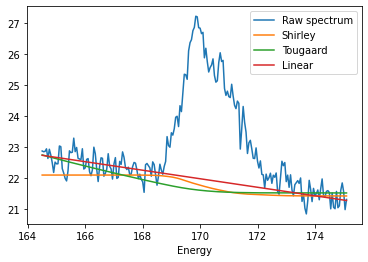

In [12]:
#@title Let's compare baseline estimation now

#@markdown Now we can load some raw S 2p XPS spectrum and try to do background
#@markdown subtraction. I had to smooth the spectrum with rolling median, window size of 15
sheet_url = 'https://docs.google.com/spreadsheets/d/1jYaWVnu8Kp69lzUcmqsHQoLSurC019vAyJQWu7atJOM/edit#gid=0'
url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

data = pd.read_csv(url)
Eph = 789.0
data['Shirley'] = getShirley(Eph-data['Energy'], data['Raw spectrum'], window=15)
data['Tougaard'] = getTougaard(Eph-data['Energy'], data['Raw spectrum'], window=15)
data['Linear'] = getLinear(Eph-data['Energy'], data['Raw spectrum'])

data.plot(x='Energy');

# References

1. A. Proctor, P.M.A. Sherwood, Anal. Chem. 54 (1982) 13
2. Repoux M. Comparison of Background Removal Methods for XPS. SURFACE AND INTERFACE ANALYSIS, VOL. 18, 567-570 (1992), doi:10.1002/sia.740180719
3. https://github.com/kaneod/physics/blob/master/python/specs.py (the algorithm for Shirley background)
4. https://github.com/hidecode221b/LG4X/blob/master/Python/xpspy.py (the algorithm for Tougaar background)
5. Pybaselines - python library which has 50+ baseline correction algorithms.
6. Sven Tougaard , "Practical guide to the use of backgrounds in quantitative XPS", Journal of Vacuum Science & Technology A 39, 011201 (2021) https://doi.org/10.1116/6.0000661